In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MaxAbsScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

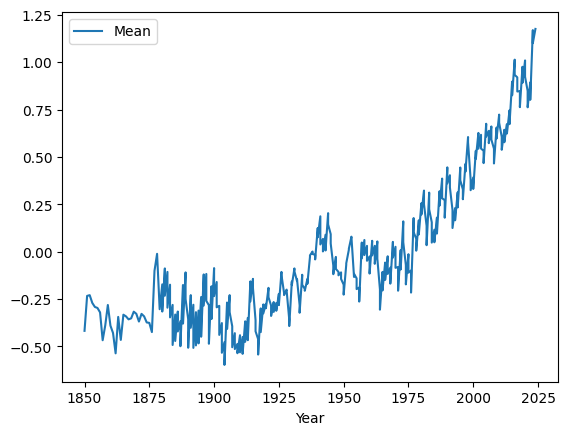

In [2]:
url = '/Users/anastasiyafostiy/Desktop/belhard/annual.csv'
data = pd.read_csv(url)
data = data.drop(columns='Source')
data.plot(x='Year', y='Mean')
plt.show()

In [3]:
train_df = data[(data['Year'] >= 1870) & (data['Year'] < 1980)]['Mean'].to_numpy()
val_df = data[(data['Year'] >= 1980) & (data['Year'] < 2000)]['Mean'].to_numpy()
test_df = data[data['Year'] < 1870]['Mean'].to_numpy()

# нормализация данных. для подачи в Scaler данные должны иметь форму 2-мерного массива
scaler = MaxAbsScaler()
scaler.fit(train_df.reshape(-1, 1))

train_df = scaler.transform(train_df.reshape(-1, 1)).flatten()
val_df = scaler.transform(val_df.reshape(-1, 1)).flatten()
test_df = scaler.transform(test_df.reshape(-1, 1)).flatten()

In [4]:
# создание последовательностей
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)


SEQ_LENGTH = 5
x_train = create_sequences(train_df, SEQ_LENGTH)
x_val = create_sequences(val_df, SEQ_LENGTH)
x_test = create_sequences(test_df, SEQ_LENGTH)

In [5]:
# добавление размерности, тк LSTM (как и др. рекуррентные сети) ожидают вход в формате
# [batch_size, seq_length, features]. если данные представляют временной ряд, features = 1 (одно измерение)
x_train = x_train[..., np.newaxis]  # (n_samples, seq_len, 1)
x_val = x_val[..., np.newaxis]
x_test = x_test[..., np.newaxis]

train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32)) # Tensor (batch, seq_len, 1)
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)    # перемешивание предотвращает переобучение, помогает модели видеть разные сочетания данных
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)    # проверка модели должна быть стабильной и воспроизводимой
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [23]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, seq_len):
        super().__init__()
        self.seq_len = seq_len

        # энкодер
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=0.3)
        self.fc_latent = nn.Linear(hidden_dim, latent_dim)  # лин.слой, кот. уменьшает размерность скрытого состояния LSTM до latent_dim

        # декодер
        self.decoder_lstm = nn.LSTM(latent_dim, hidden_dim, batch_first=True, dropout=0.3)
        self.output_layer = nn.Linear(hidden_dim, input_dim)    # лин. слой, кот. преобразует скрытые состояния обратно в input_dim

    def forward(self, x):
        # кодирование
        _, (hidden, _) = self.encoder(x)
        latent = self.fc_latent(hidden.squeeze(0))  # [batch_size, latent_dim]

        # расширение латентного представления для декодера
        repeated_latent = latent.unsqueeze(1).repeat(1, self.seq_len, 1)    # unsqueeze - добавляет размерность [batch_size, 1, latent_dim], repeat(1, self.seq_len, 1) - повторяет латентное представление seq_len раз

        # декодирование
        decoded, _ = self.decoder_lstm(repeated_latent)
        output = self.output_layer(decoded)  # [batch_size, seq_len, input_dim]

        return output


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMAutoencoder(seq_len=SEQ_LENGTH, latent_dim=32, input_dim=1, hidden_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.006)
loss_fn = nn.MSELoss()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [24]:
# обучение модели

n_epochs = 100
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 20  # кол-во эпох без улучшения перед остановкой
early_stop_counter = 0  # счётчик эпох без улучшения

for epoch in range(n_epochs):
    model.train()
    epoch_train_loss = 0
    for batch in train_loader:
        x_batch = batch[0].to(device)

        optimizer.zero_grad()
        reconstructed = model(x_batch)

        loss = loss_fn(reconstructed, x_batch)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))

    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            x_batch = batch[0].to(device)
            reconstructed = model(x_batch)
            loss = loss_fn(reconstructed, x_batch)
            epoch_val_loss += loss.item()

    val_losses.append(epoch_val_loss / len(val_loader))

    # проверка как EarlyStopping
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        torch.save(model.state_dict(), 'best_model.pth')
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    print(f'Epoch {epoch + 1}/{n_epochs} | Train Loss: {train_losses[-1]:.6f} | Val Loss: {val_losses[-1]:.6f}')

    if early_stop_counter >= patience:
        print("Early stopping triggered!")
        break

model.load_state_dict(torch.load('best_model.pth'))

Epoch 1/100 | Train Loss: 0.119667 | Val Loss: 0.921248
Epoch 2/100 | Train Loss: 0.088689 | Val Loss: 0.666146
Epoch 3/100 | Train Loss: 0.067956 | Val Loss: 0.485585
Epoch 4/100 | Train Loss: 0.033727 | Val Loss: 0.225821
Epoch 5/100 | Train Loss: 0.030851 | Val Loss: 0.243533
Epoch 6/100 | Train Loss: 0.024497 | Val Loss: 0.242755
Epoch 7/100 | Train Loss: 0.023613 | Val Loss: 0.169232
Epoch 8/100 | Train Loss: 0.022557 | Val Loss: 0.140279
Epoch 9/100 | Train Loss: 0.022275 | Val Loss: 0.154428
Epoch 10/100 | Train Loss: 0.021902 | Val Loss: 0.134610
Epoch 11/100 | Train Loss: 0.020948 | Val Loss: 0.117582
Epoch 12/100 | Train Loss: 0.021470 | Val Loss: 0.119224
Epoch 13/100 | Train Loss: 0.021465 | Val Loss: 0.104420
Epoch 14/100 | Train Loss: 0.021306 | Val Loss: 0.089660
Epoch 15/100 | Train Loss: 0.021535 | Val Loss: 0.087726
Epoch 16/100 | Train Loss: 0.021387 | Val Loss: 0.080007
Epoch 17/100 | Train Loss: 0.021479 | Val Loss: 0.074673
Epoch 18/100 | Train Loss: 0.021836 | Va

<All keys matched successfully>

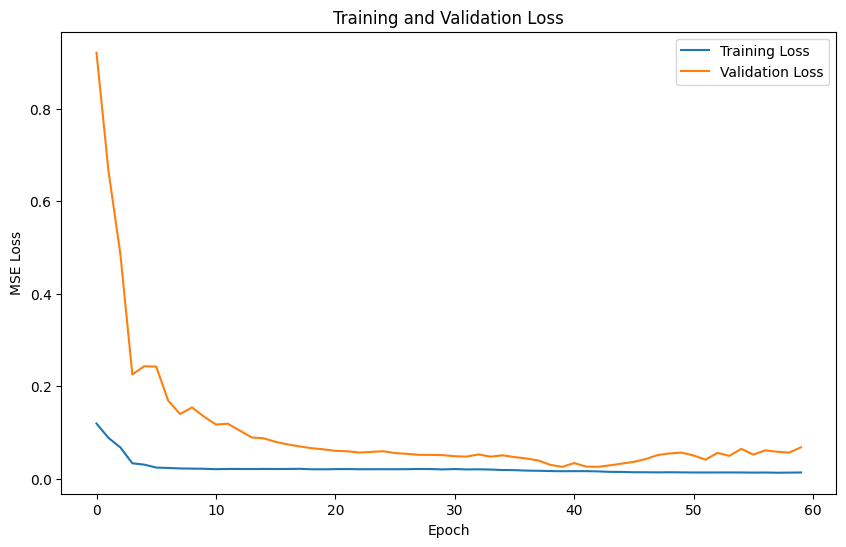

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [28]:
# тестирование на участке 1850 - 1870 г.

model.eval()
test_reconstructions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch = batch[0].to(device)
        reconstructed = model(x_batch).cpu().numpy()
        test_reconstructions.append(reconstructed)

test_reconstructions = np.vstack(test_reconstructions)

original_test = scaler.inverse_transform(x_test.squeeze(-1).reshape(-1, 1)) # x_test - (15, 4, 1) to (15, 4) to (60, 1)
reconstructed_test = scaler.inverse_transform(test_reconstructions.squeeze(-1).reshape(-1, 1))
reconstruction_error = np.mean(np.abs(original_test - reconstructed_test), axis=0)
print(f"Average reconstruction error: {reconstruction_error[0]:.4f} °C")

Average reconstruction error: 0.0509 °C


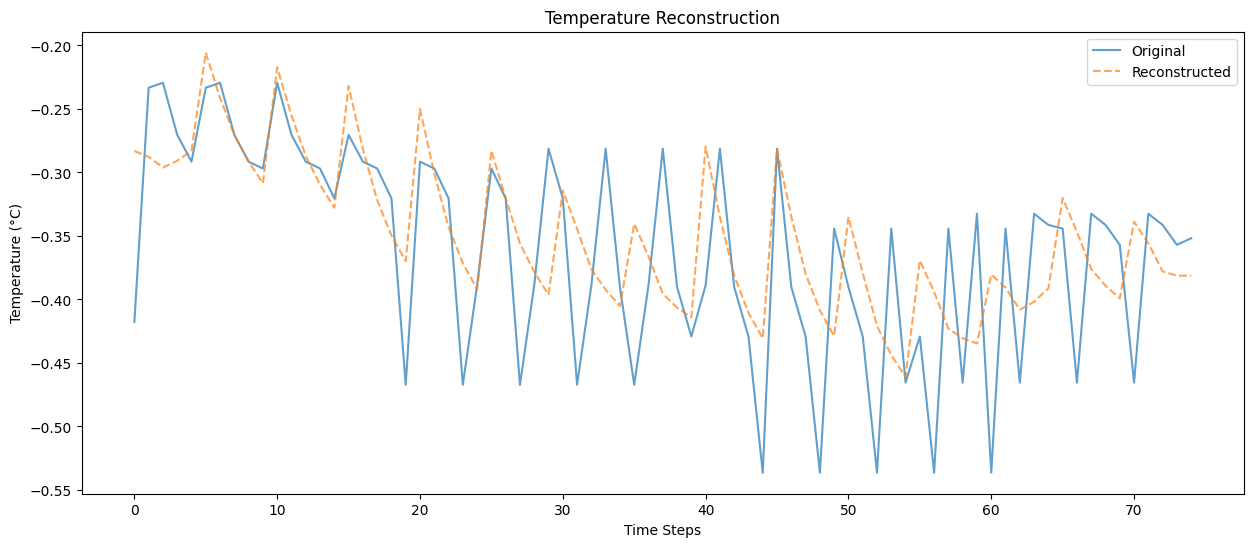

In [29]:
plt.figure(figsize=(15, 6))
plt.plot(original_test, label='Original', alpha=0.7)
plt.plot(reconstructed_test, label='Reconstructed', linestyle='--', alpha=0.7)
plt.title('Temperature Reconstruction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

Reconstruction error threshold:  0.2360805
Average reconstruction error: 0.0659 °C


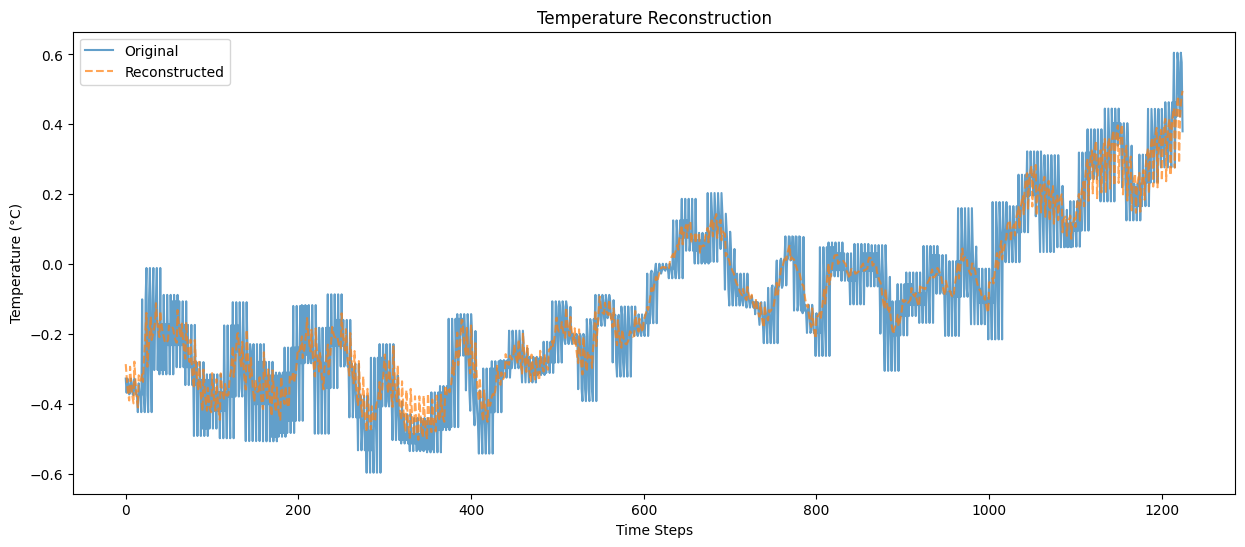

In [34]:
# проверка на аномалию в тестовом датасете на участке 2000 - 2025 г.

# вычисление максимальной MAE на трейновом и валидационном датасете. принятие ее за threshold

train_val_df = data[(data['Year'] >= 1870) & (data['Year'] < 2000)]['Mean'].to_numpy()
train_val_df = scaler.transform(train_val_df.reshape(-1, 1)).flatten()
x_train_val = create_sequences(train_val_df, SEQ_LENGTH)
x_train_val = x_train_val[..., np.newaxis]
train_val_dataset = TensorDataset(torch.tensor(x_train_val, dtype=torch.float32))
train_val_loader = DataLoader(train_val_dataset, batch_size=1, shuffle=False)

model.eval()
threshold = 0.0
tv_pred = []
with torch.no_grad():
    for x_batch in train_val_loader:
        x_batch = x_batch[0].to(device)
        reconstructed = model(x_batch).cpu().numpy()
        tv_pred.append(reconstructed)
        mae_loss = np.mean(np.abs(reconstructed - x_batch.numpy()))
        if mae_loss > threshold:
            threshold = mae_loss

tv_pred = np.vstack(tv_pred)
original = scaler.inverse_transform(x_train_val.squeeze(-1).reshape(-1, 1))
reconstructed_tv = scaler.inverse_transform(tv_pred.squeeze(-1).reshape(-1, 1))
reconstruction_error = np.mean(np.abs(original - reconstructed_tv), axis=0)

print("Reconstruction error threshold: ", threshold)
print(f"Average reconstruction error: {reconstruction_error[0]:.4f} °C")

plt.figure(figsize=(15, 6))
plt.plot(original, label='Original', alpha=0.7)
plt.plot(reconstructed_tv, label='Reconstructed', linestyle='--', alpha=0.7)
plt.title('Temperature Reconstruction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

Average reconstruction error: 0.2122 °C
Number of anomaly samples 26 out of 44 samples
Indices of anomaly samples:  (array([10, 14, 17, 18, 19, 20, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43]),)


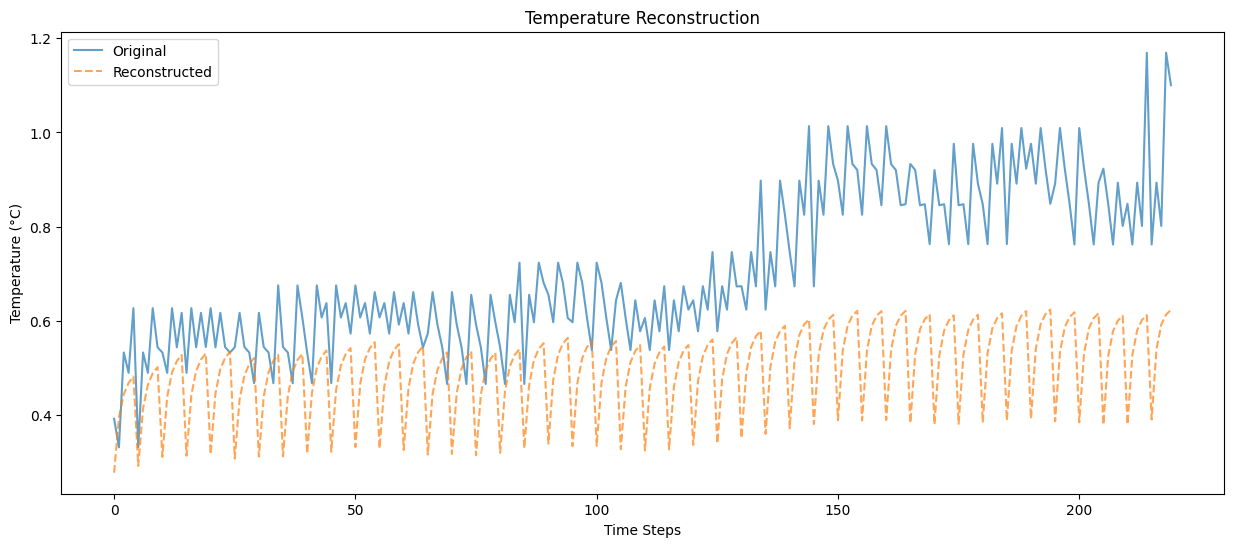

In [35]:
# вычисление MAE на тестовом датасете. MAE > threshold ==> аномалия

test_df = data[data['Year'] >= 2000]['Mean'].to_numpy()
test_df = scaler.transform(test_df.reshape(-1, 1)).flatten()
x_test = create_sequences(test_df, SEQ_LENGTH)
x_test = x_test[..., np.newaxis]
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, shuffle=False)

model.eval()
test_reconstructions = []
test_losses = []
with torch.no_grad():
    for batch in test_loader:
        x_batch = batch[0].to(device)
        reconstructed = model(x_batch).cpu().numpy()
        test_reconstructions.append(reconstructed)
        mae_loss = np.mean(np.abs(reconstructed - x_batch.numpy()))
        test_losses.append(mae_loss)

test_losses = np.array(test_losses).reshape((-1))
anomalies = test_losses > threshold

test_reconstructions = np.vstack(test_reconstructions)
original_test = scaler.inverse_transform(x_test.squeeze(-1).reshape(-1, 1))
reconstructed_test = scaler.inverse_transform(test_reconstructions.squeeze(-1).reshape(-1, 1))
reconstruction_error = np.mean(np.abs(original_test - reconstructed_test), axis=0)

print(f"Average reconstruction error: {reconstruction_error[0]:.4f} °C")
print(f"Number of anomaly samples {np.sum(anomalies)} out of {len(test_losses)} samples")
print("Indices of anomaly samples: ", np.where(anomalies))

plt.figure(figsize=(15, 6))
plt.plot(original_test, label='Original', alpha=0.7)
plt.plot(reconstructed_test, label='Reconstructed', linestyle='--', alpha=0.7)
plt.title('Temperature Reconstruction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()